(time_series_generative_graph)=
# Time Series Models Derived From a Generative Graph

:::{post} March, 2024
:tags: time-series, 
:category: intermediate, reference
:author: Jesse Grabowski, Juan Orduz and Ricardo Vieira
:::

In this notebook, we show how to model and fit a time series model starting from a generative graph. In particular, we explain how to use {func}`scan <pytensor.scan.basic.scan>` to loop efficiently inside a PyMC model.

:::{admonition} **Motivation**
:class: note

Why would we do that, instead of just using {class}`~pymc.distributions.timeseries.AR`? What are the benefits? 

The pre-built time series models in PyMC are very useful and easy to use. Nevertheless, they are not flexible enough to model more complex time series models. By using a generative graph, we can model any time series model we want, as long as we can define it in terms of a generative graph. For example:

- Auto-regressive models with different noise distribution (e.g. {class}`~pymc.distributions.continuous.StudentT` noise).
- Exponential smoothing models.
- ARIMA-GARCH models.
:::

For this example, we consider an autoregressive model AR(2). Recall that an AR(2) model is defined as:

$$
\begin{align*}
y_t &= \rho_1 y_{t-1} + \rho_2 y_{t-2} + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
\end{align*}
$$

That is, we have a recursive linear model in term of the first two lags of the time series.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pymc.pytensorf import collect_default_updates

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

rng = np.random.default_rng(42)

## Define AR(2) Process

We start by encoding the generative graph of the AR(2) model as a function `ar_dist`. The strategy is to pass this function as a custom distribution via {class}`~pymc.CustomDist` inside a PyMC model. 

We need to specify the initial state (`ar_init`), the autoregressive coefficients (`rho`), and the standard deviation of the noise (`sigma`). Given such parameters, we can define the generative graph of the AR(2) model using the  {meth}`scan <pytensor.scan.basic.scan>` operation.

:::{admonition} **What are all of these functions?**
:class: note

At first, it might seem a bit overwhelming to see all these functions. However, they are just helper functions to define the generative graph of the AR(2) model.

- {meth}`~pymc.pytensorf.collect_default_updates` tells PyMC that the random variable (RV) in the generative graph should be updated in every iteration of the loop. 

- {meth}`scan <pytensor.scan.basic.scan>` is an efficient way to loop inside a PyMC model. It is similar to the `for` loop in Python, but it is optimized for `pytensor`. We need to specify the following arguments:

    - `fn`: The function that defines the transition steep.
    - `outputs_info`: The is the list of variables or dictionaries describing the initial state of the outputs computed recurrently.
    - `non_sequences`: The list of arguments that are passed to `fn` at each steps. In this case are the autoregressive coefficients and the noise standard deviation of the AR(2) model.
    - `n_steps`: The number of steps to loop.
    - `strict`:  If `True`, all the shared variables used in `fn` must be provided as a part of `non_sequences` or `sequences` (In this example we do not use the argument `sequences`, which is the list of variables or dictionaries describing the sequences `scan` has to iterate over. In this case we can simply loop over the time steps).
:::

Let's see concrete implementations:

In [2]:
lags = 2  # Number of lags
trials = 100  # Time series length


def ar_dist(ar_init, rho, sigma, size):
    # This is the transition function for the AR(2) model.
    # We take as inputs previous steps and then specify the autoregressive relationship.
    # Finally, we add Gaussian noise to the model.
    def ar_step(x_tm2, x_tm1, rho, sigma):
        mu = x_tm1 * rho[0] + x_tm2 * rho[1]
        x = mu + pm.Normal.dist(sigma=sigma)
        return x, collect_default_updates([x])

    # Here we actually "loop" over the time series.
    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps": range(-lags, 0)}],
        non_sequences=[rho, sigma],
        n_steps=trials - lags,
        strict=True,
    )

    return ar_innov

## Generate AR(2) Graph

Now that we have implemented the AR(2) step, we can assign priors to the parameters `rho` and `sigma`. We also specify the initial state `ar_init` as a zero vector.

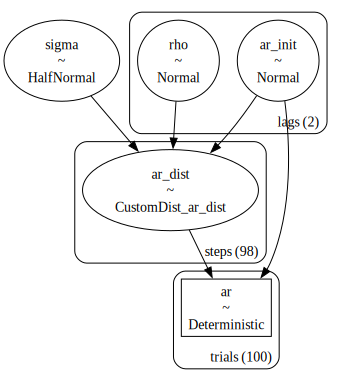

In [3]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(trials - lags),
    "trials": range(trials),
}
with pm.Model(coords=coords, check_bounds=False) as model:
    rho = pm.Normal(name="rho", mu=0, sigma=0.2, dims=("lags",))
    sigma = pm.HalfNormal(name="sigma", sigma=0.2)

    ar_init = pm.Normal(name="ar_init", sigma=0.5, dims=("lags",))

    ar_innov = pm.CustomDist(
        "ar_dist",
        ar_init,
        rho,
        sigma,
        dist=ar_dist,
        dims=("steps",),
    )

    ar = pm.Deterministic(
        name="ar", var=pt.concatenate([ar_init, ar_innov], axis=-1), dims=("trials",)
    )


pm.model_to_graphviz(model)

## Prior

Let's sample from the prior distribution to see how the AR(2) model behaves.

In [4]:
with model:
    prior = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [ar_dist, ar_init, rho, sigma]


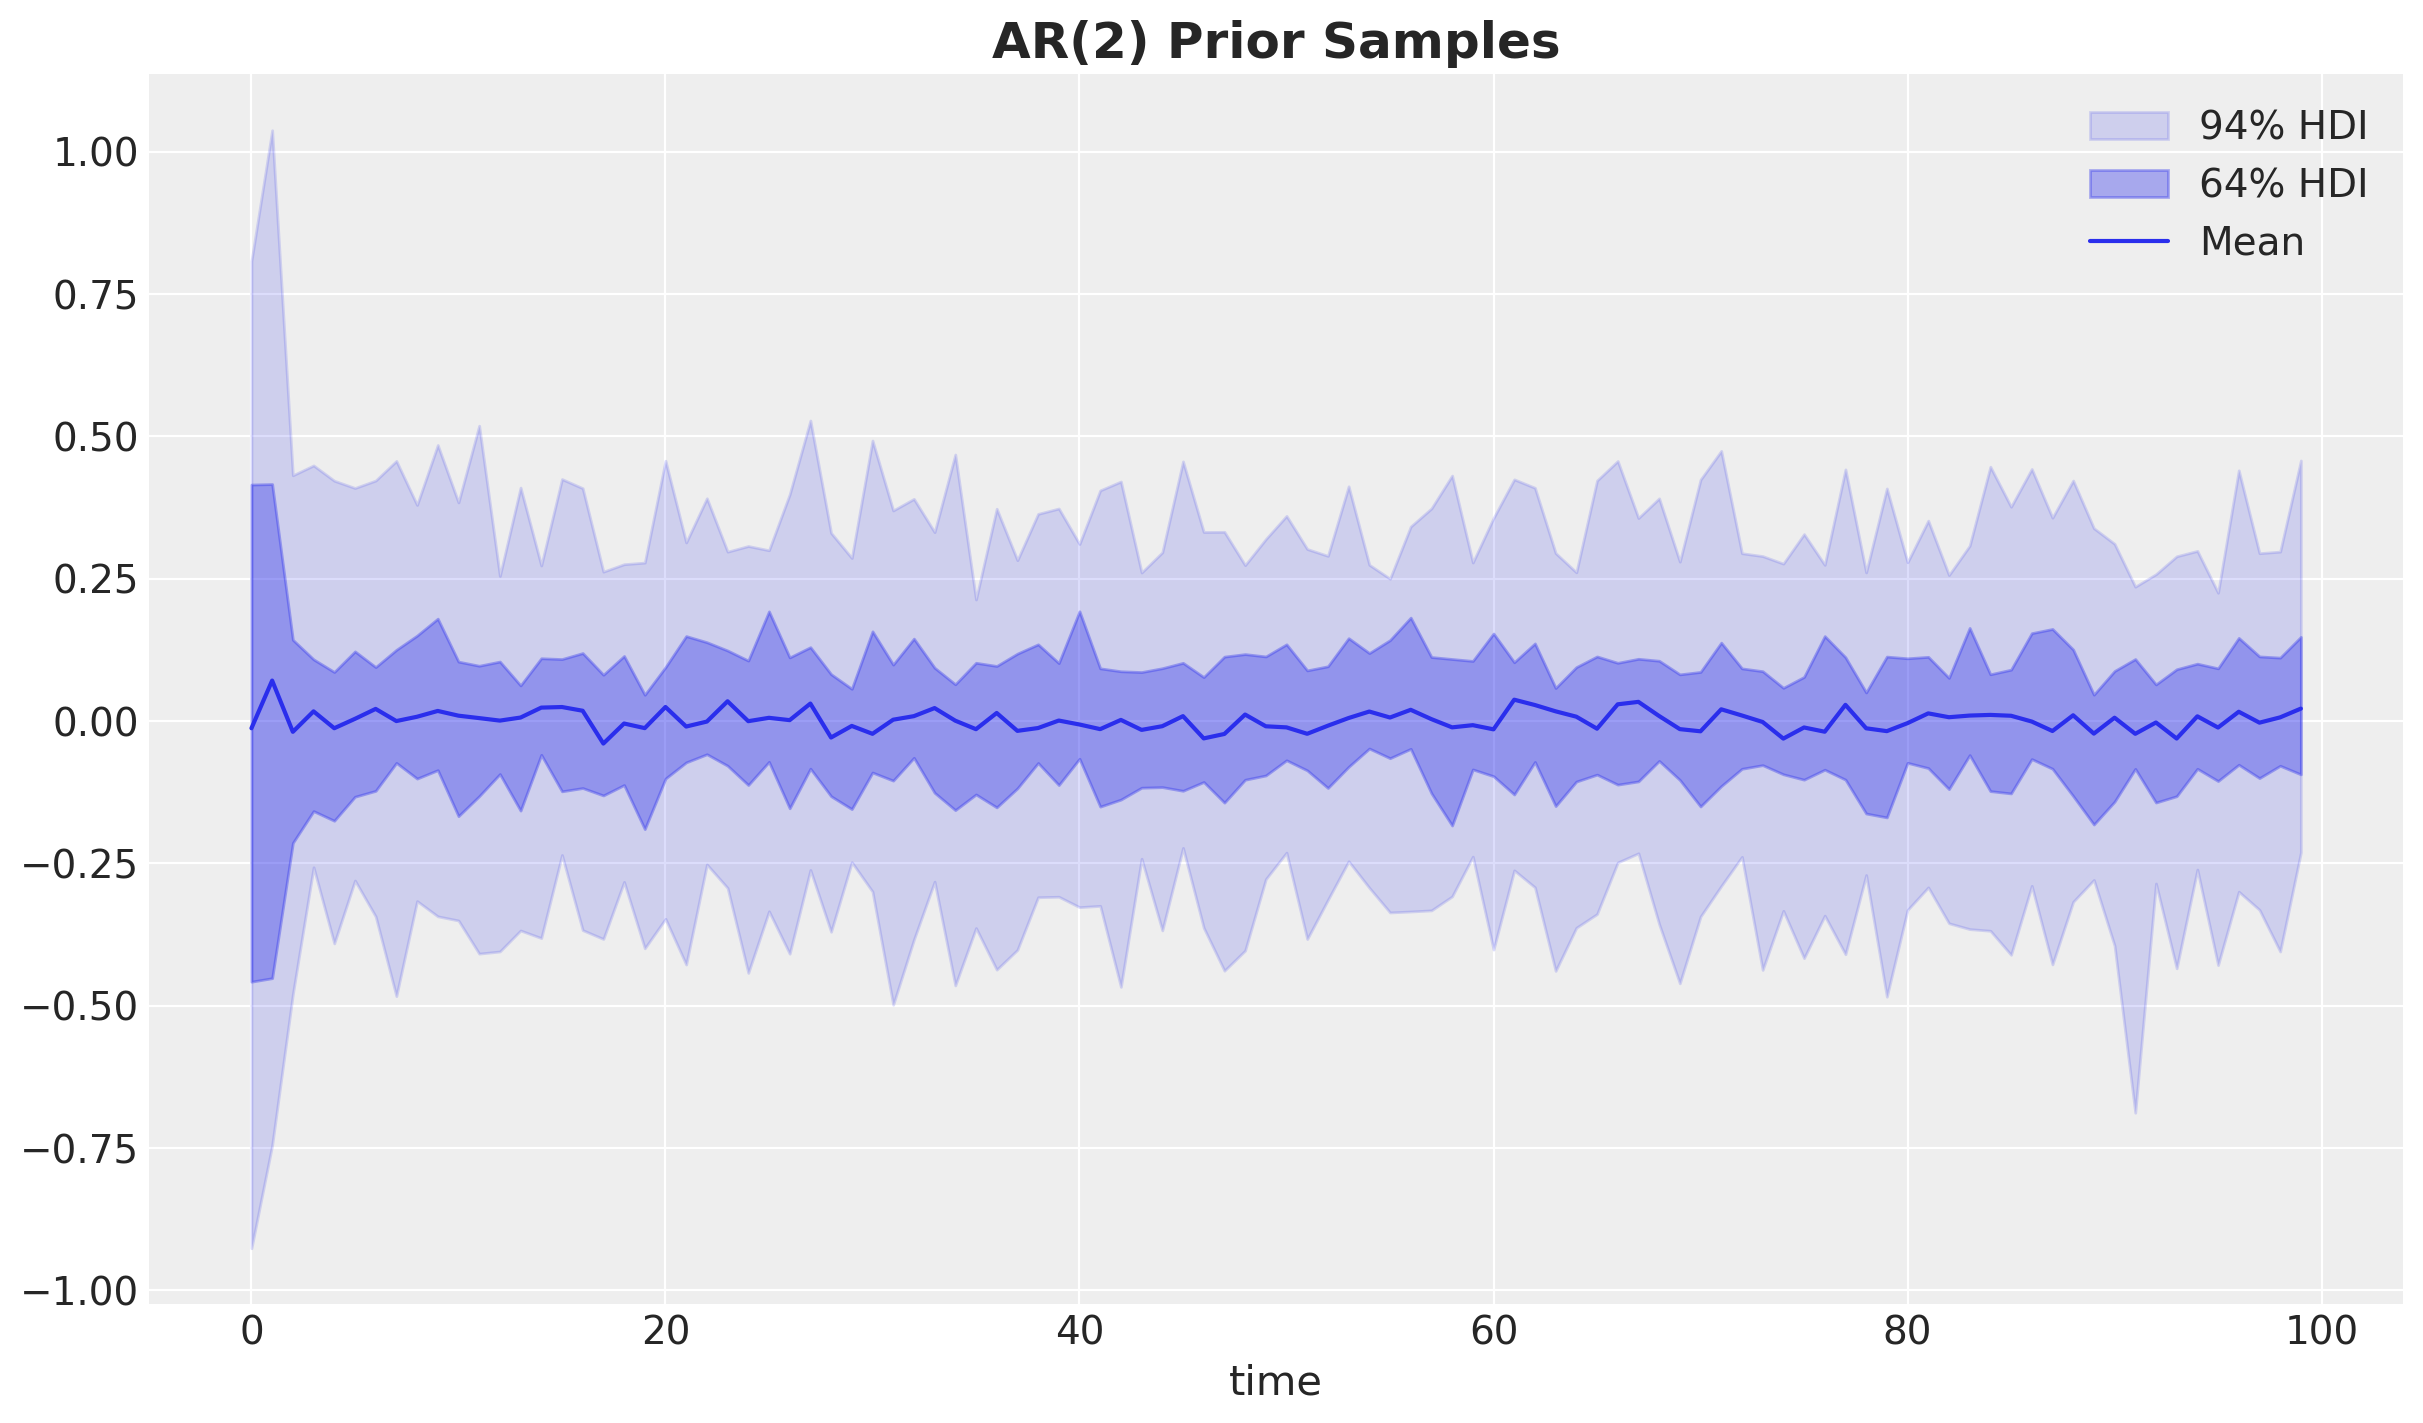

In [5]:
_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(prior.prior["ar"], hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(trials),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0", label="Mean")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Prior Samples", fontsize=18, fontweight="bold");

It is not surprising that the prior distribution is a stationary process around zero given that the prior of the  `rho` parameter is far from one.

Let's look into individual samples to get a feeling of the heterogeneity of the generated series:

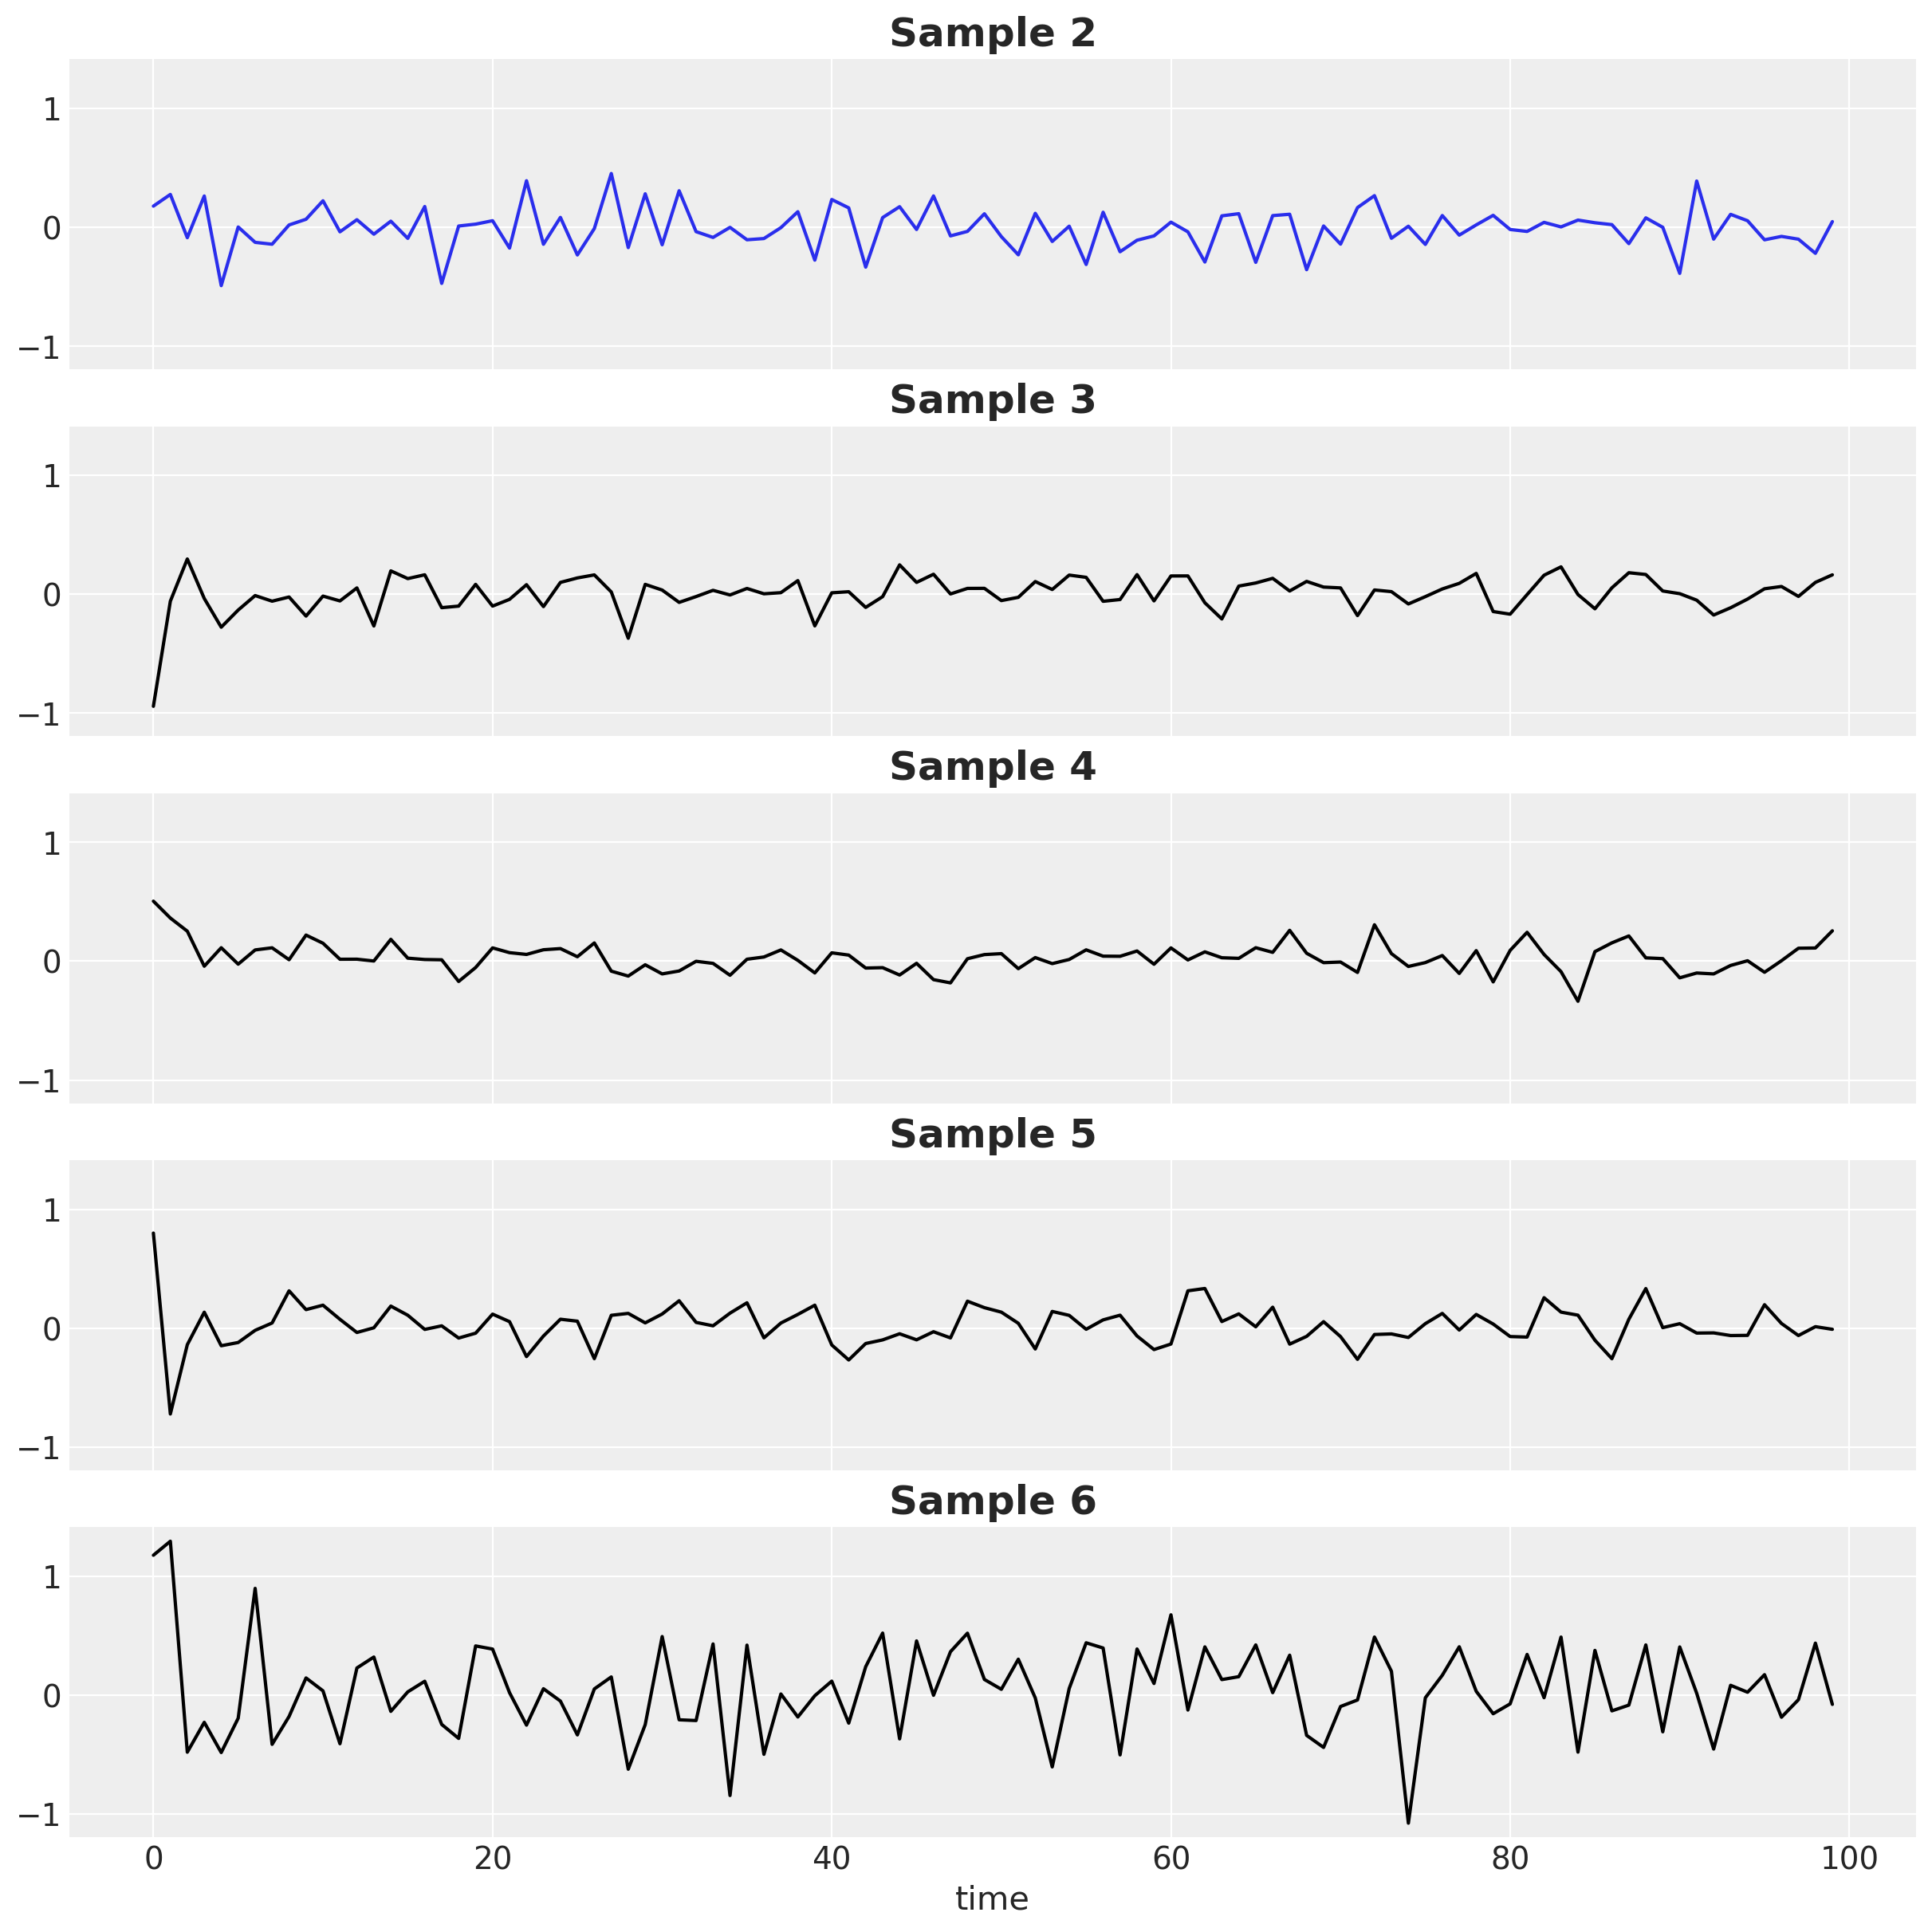

In [6]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12), sharex=True, sharey=True, layout="constrained"
)
chosen_draw = 2
for i, axi in enumerate(ax, start=chosen_draw):
    axi.plot(
        prior.prior["ar"].isel(draw=i, chain=0),
        color="C0" if i == chosen_draw else "black",
    )
    axi.set_title(f"Sample {i}", fontsize=18, fontweight="bold")
ax[-1].set_xlabel("time");

## Posterior

Next, we want to condition the AR(2) model on some observed data so that we can do a parameter recovery analysis.

In [7]:
# select a random draw from the prior
prior_draw = prior.prior.isel(chain=0, draw=chosen_draw)
test_data = prior_draw["ar_dist"].values

with pm.observe(model, {"ar_dist": test_data}) as observed_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma, ar_init]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


Let's plot the trace and the posterior distribution of the parameters.

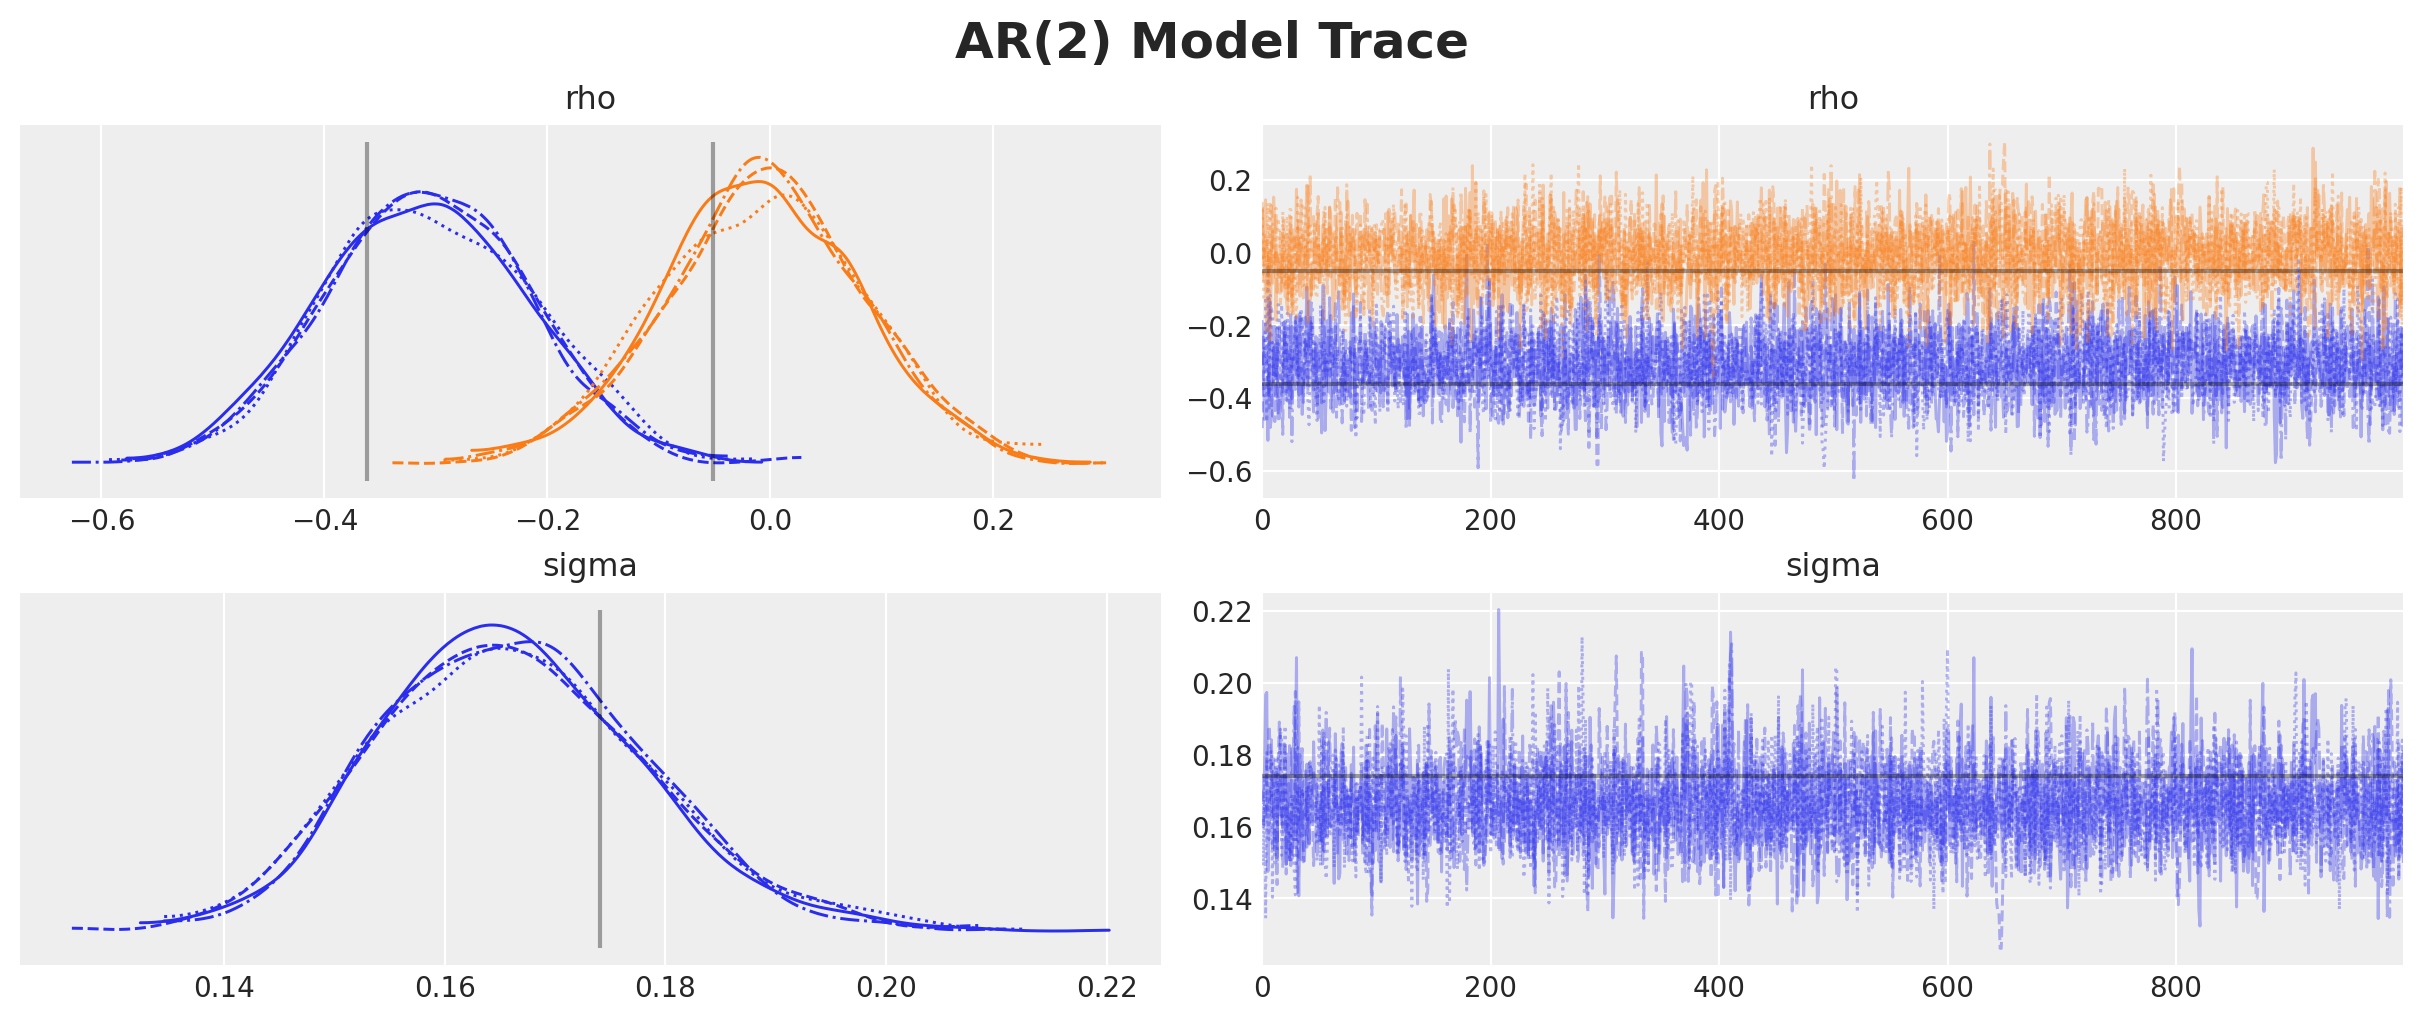

In [8]:
# Get the true values of the parameters from the prior draw
rho_true = prior_draw["rho"].to_numpy()
sigma_true = prior_draw["sigma"].to_numpy()
ar_obs = prior_draw["ar"].to_numpy()

axes = az.plot_trace(
    data=trace,
    var_names=["rho", "sigma"],
    compact=True,
    lines=[
        ("rho", {}, rho_true),
        ("sigma", {}, sigma_true),
    ],
    backend_kwargs={"figsize": (12, 5), "layout": "constrained"},
)
plt.gcf().suptitle("AR(2) Model Trace", fontsize=18, fontweight="bold");

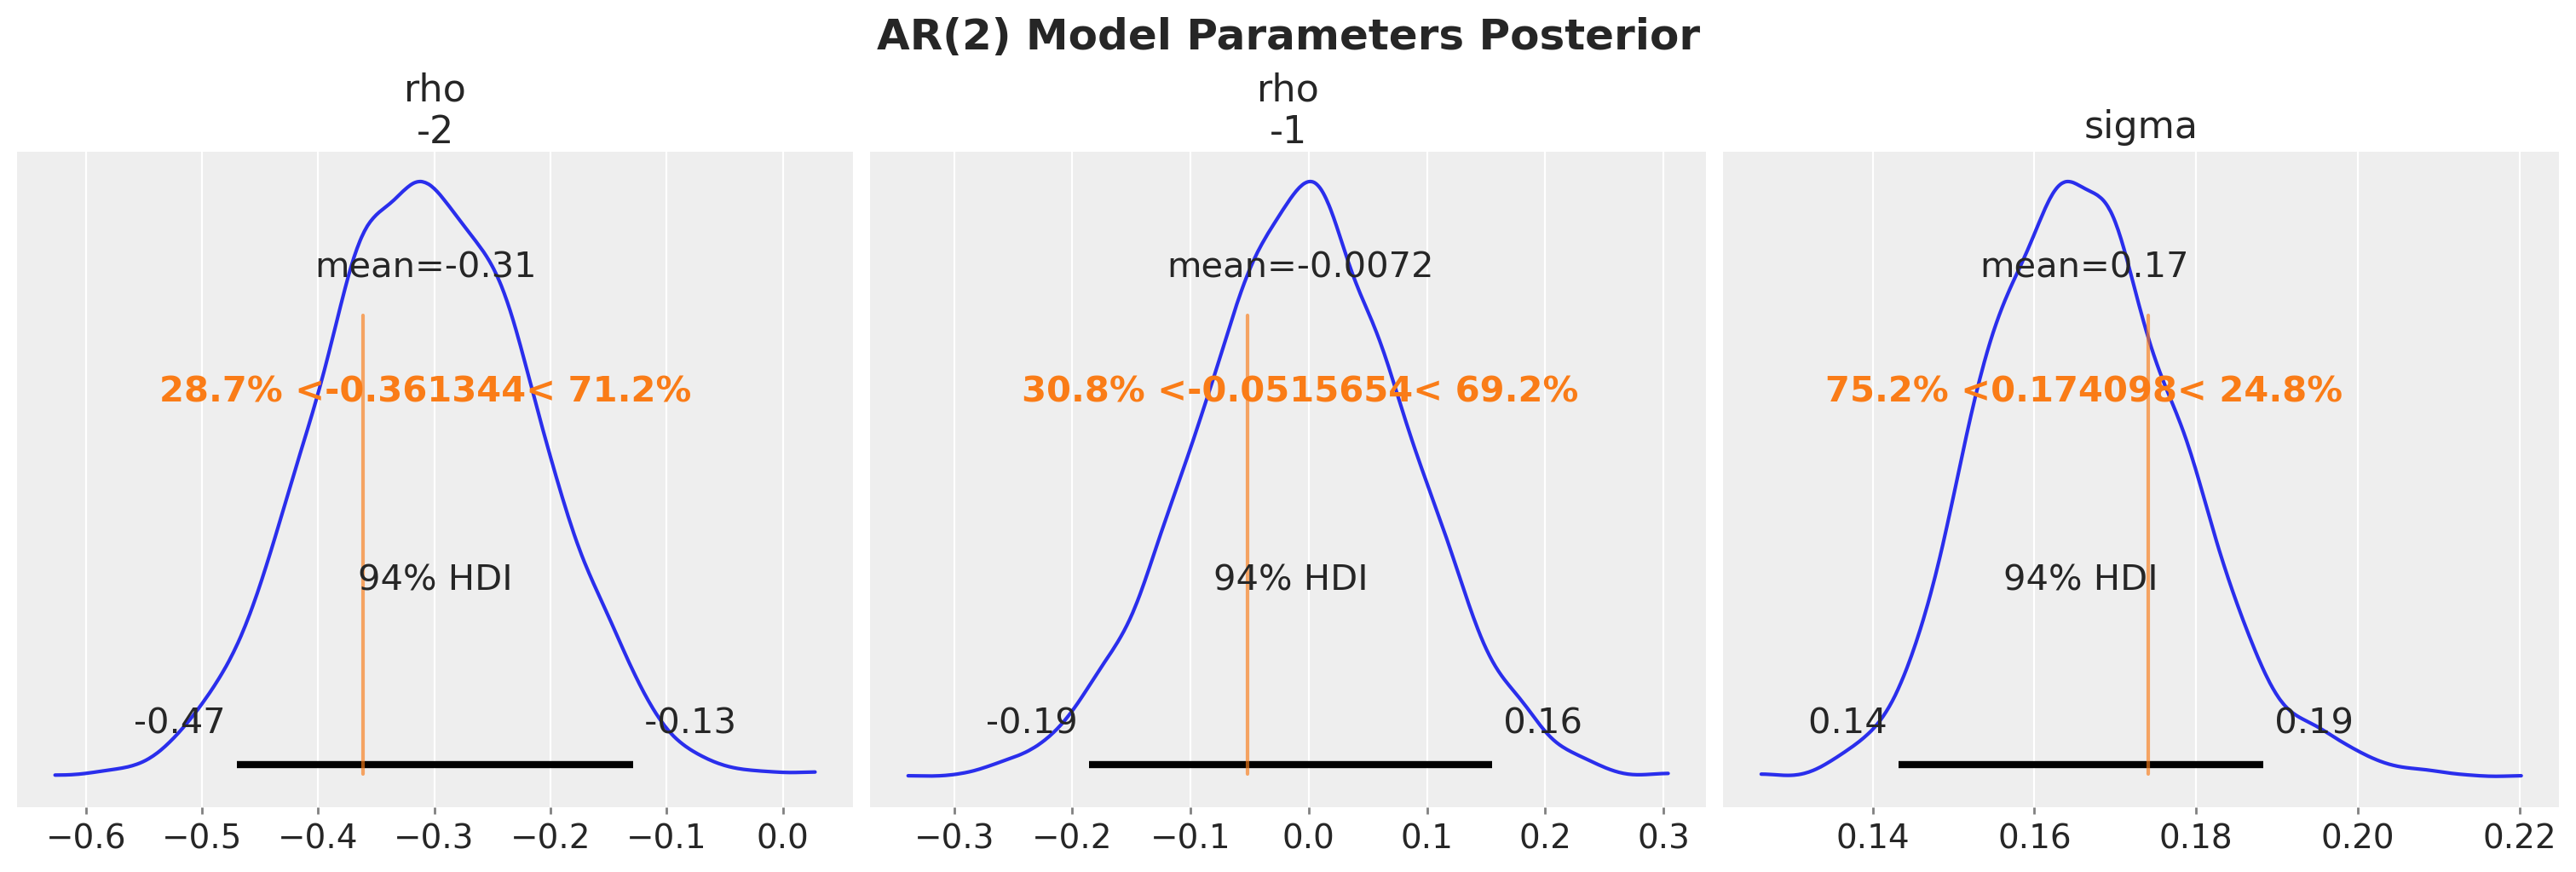

In [9]:
axes = az.plot_posterior(
    trace, var_names=["rho", "sigma"], ref_val=[*rho_true, sigma_true], figsize=(15, 5)
)
plt.gcf().suptitle("AR(2) Model Parameters Posterior", fontsize=18, fontweight="bold");

We see we have successfully recovered the true parameters of the model.

## Posterior Predictive

Finally, we can use the posterior samples to generate new data from the AR(2) model. We can then compare the generated data with the observed data to check the goodness of fit of the model.

In [10]:
with observed_model:
    post_pred = pm.sample_posterior_predictive(trace, random_seed=rng)

Sampling: [ar_dist]


Output()

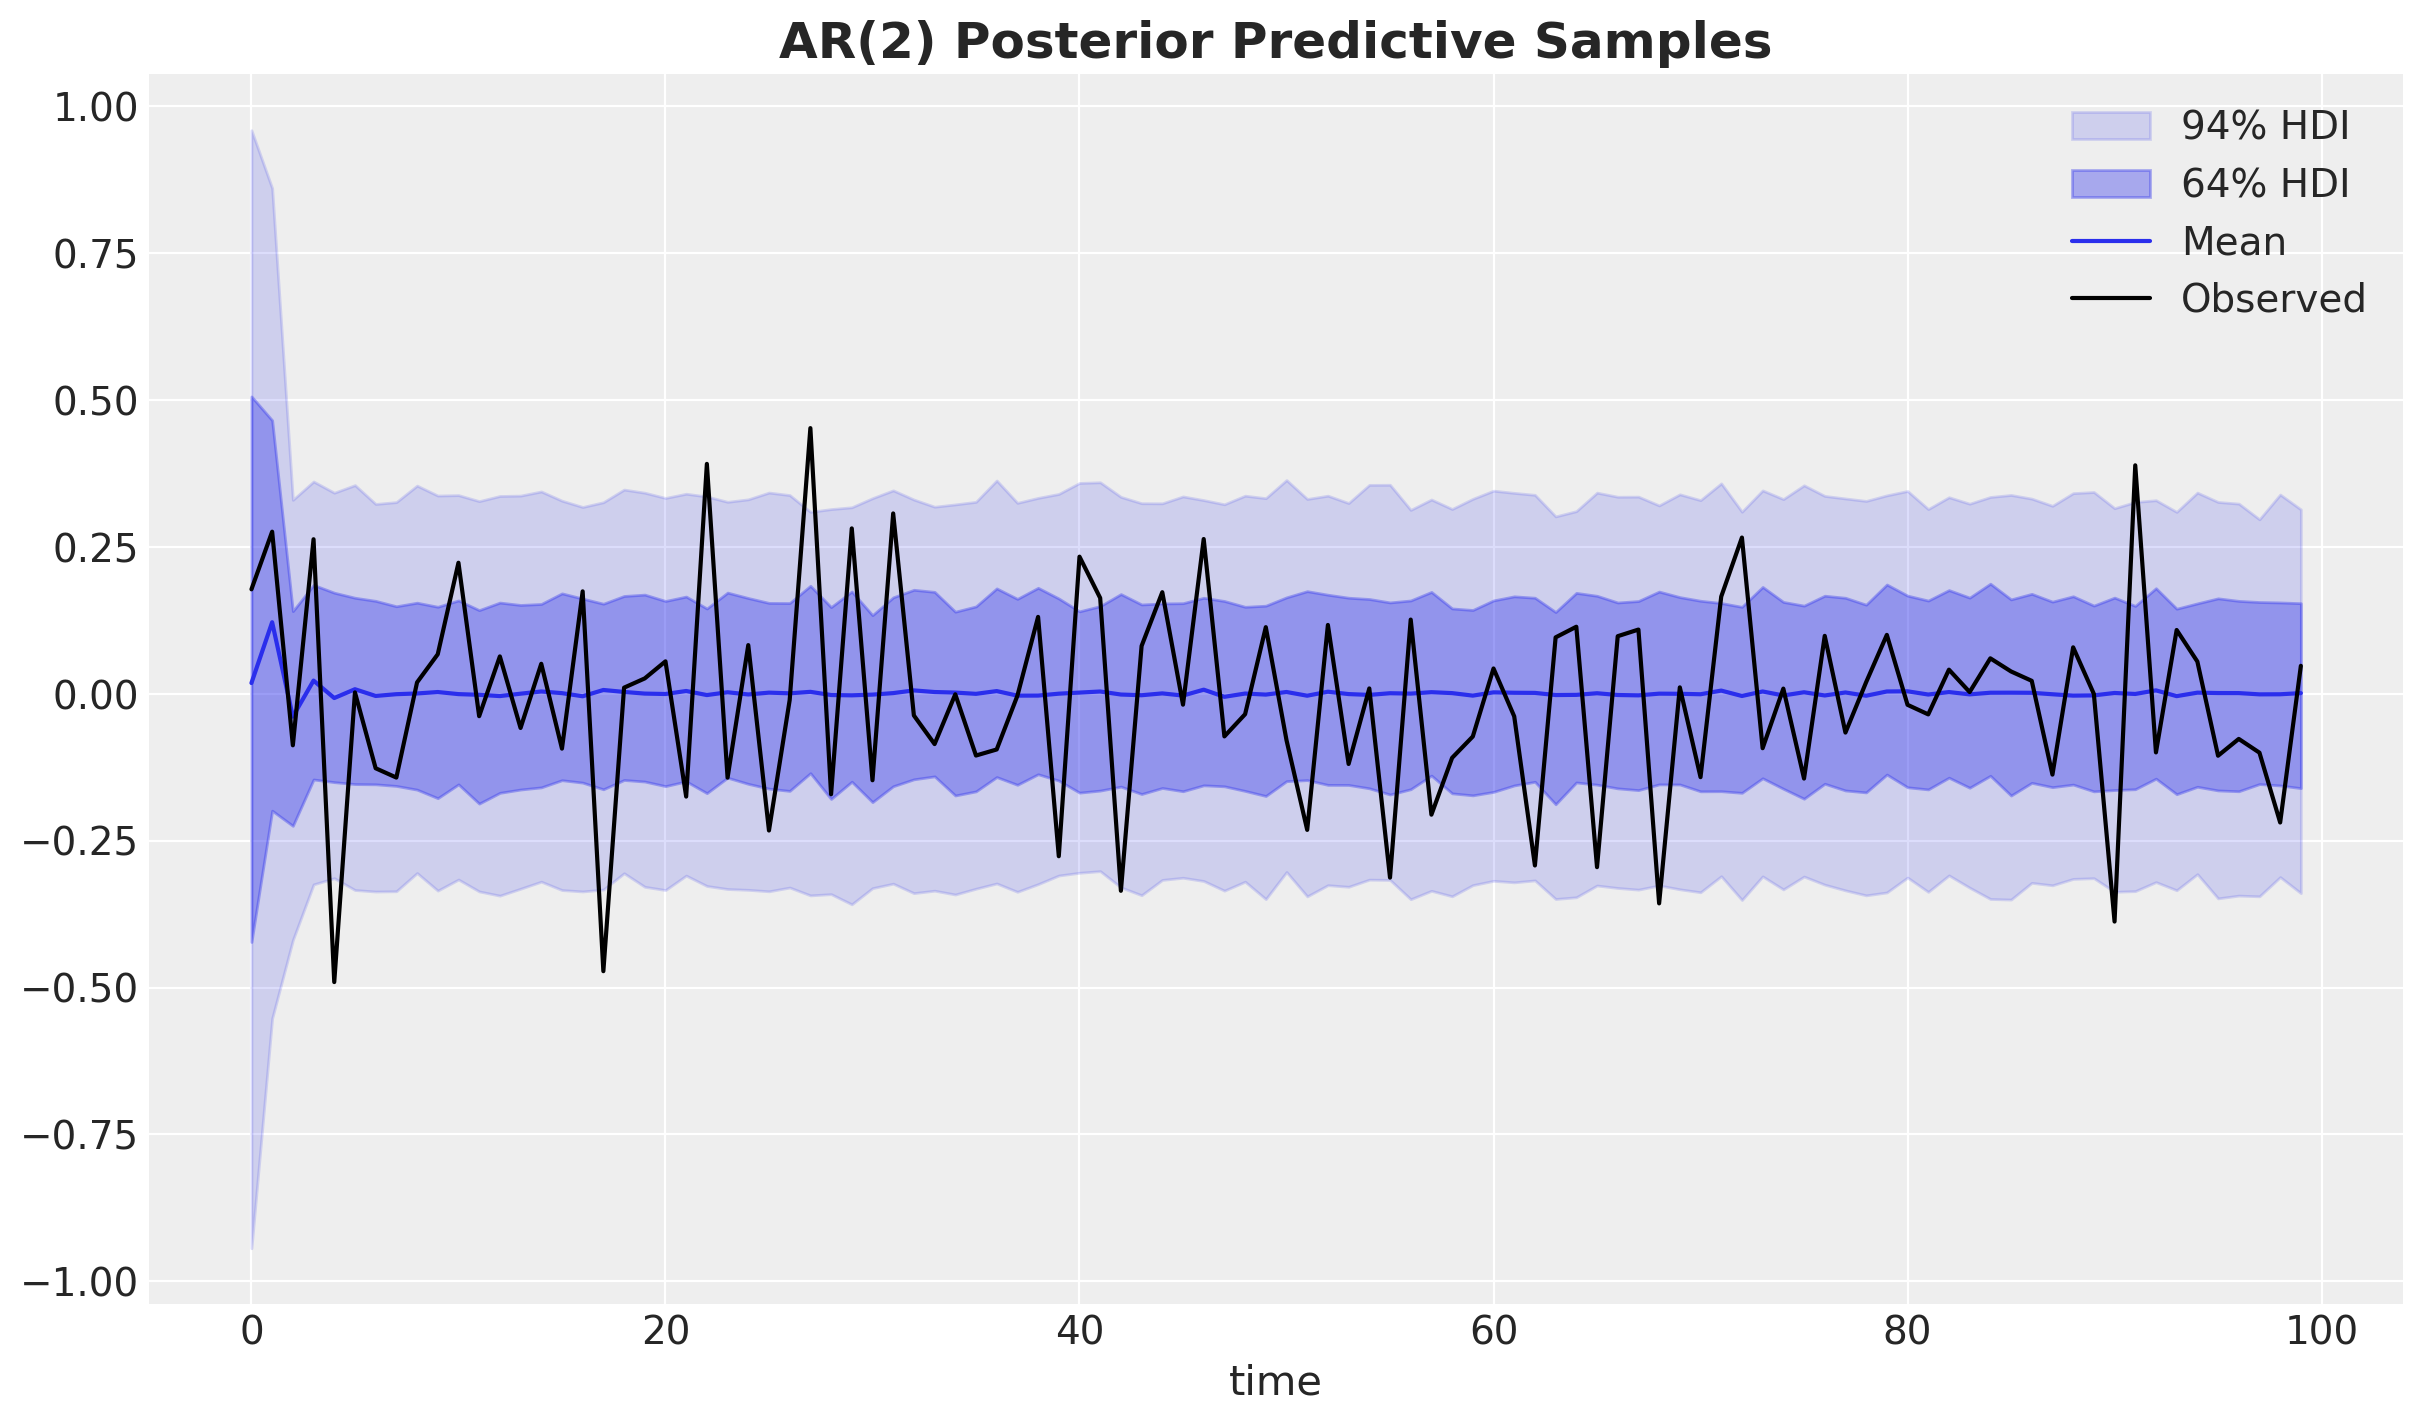

In [11]:
post_pred_ar = post_pred.posterior_predictive["ar"]

_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(trials),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(post_pred_ar.mean(("chain", "draw")), color="C0", label="Mean")
ax.plot(ar_obs, color="black", label="Observed")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Posterior Predictive Samples", fontsize=18, fontweight="bold");

Overall, we see the model is capturing the global dynamics of the time series. In order to have a better insight of the model, we can plot a subset of the posterior samples and compare them with the observed data.

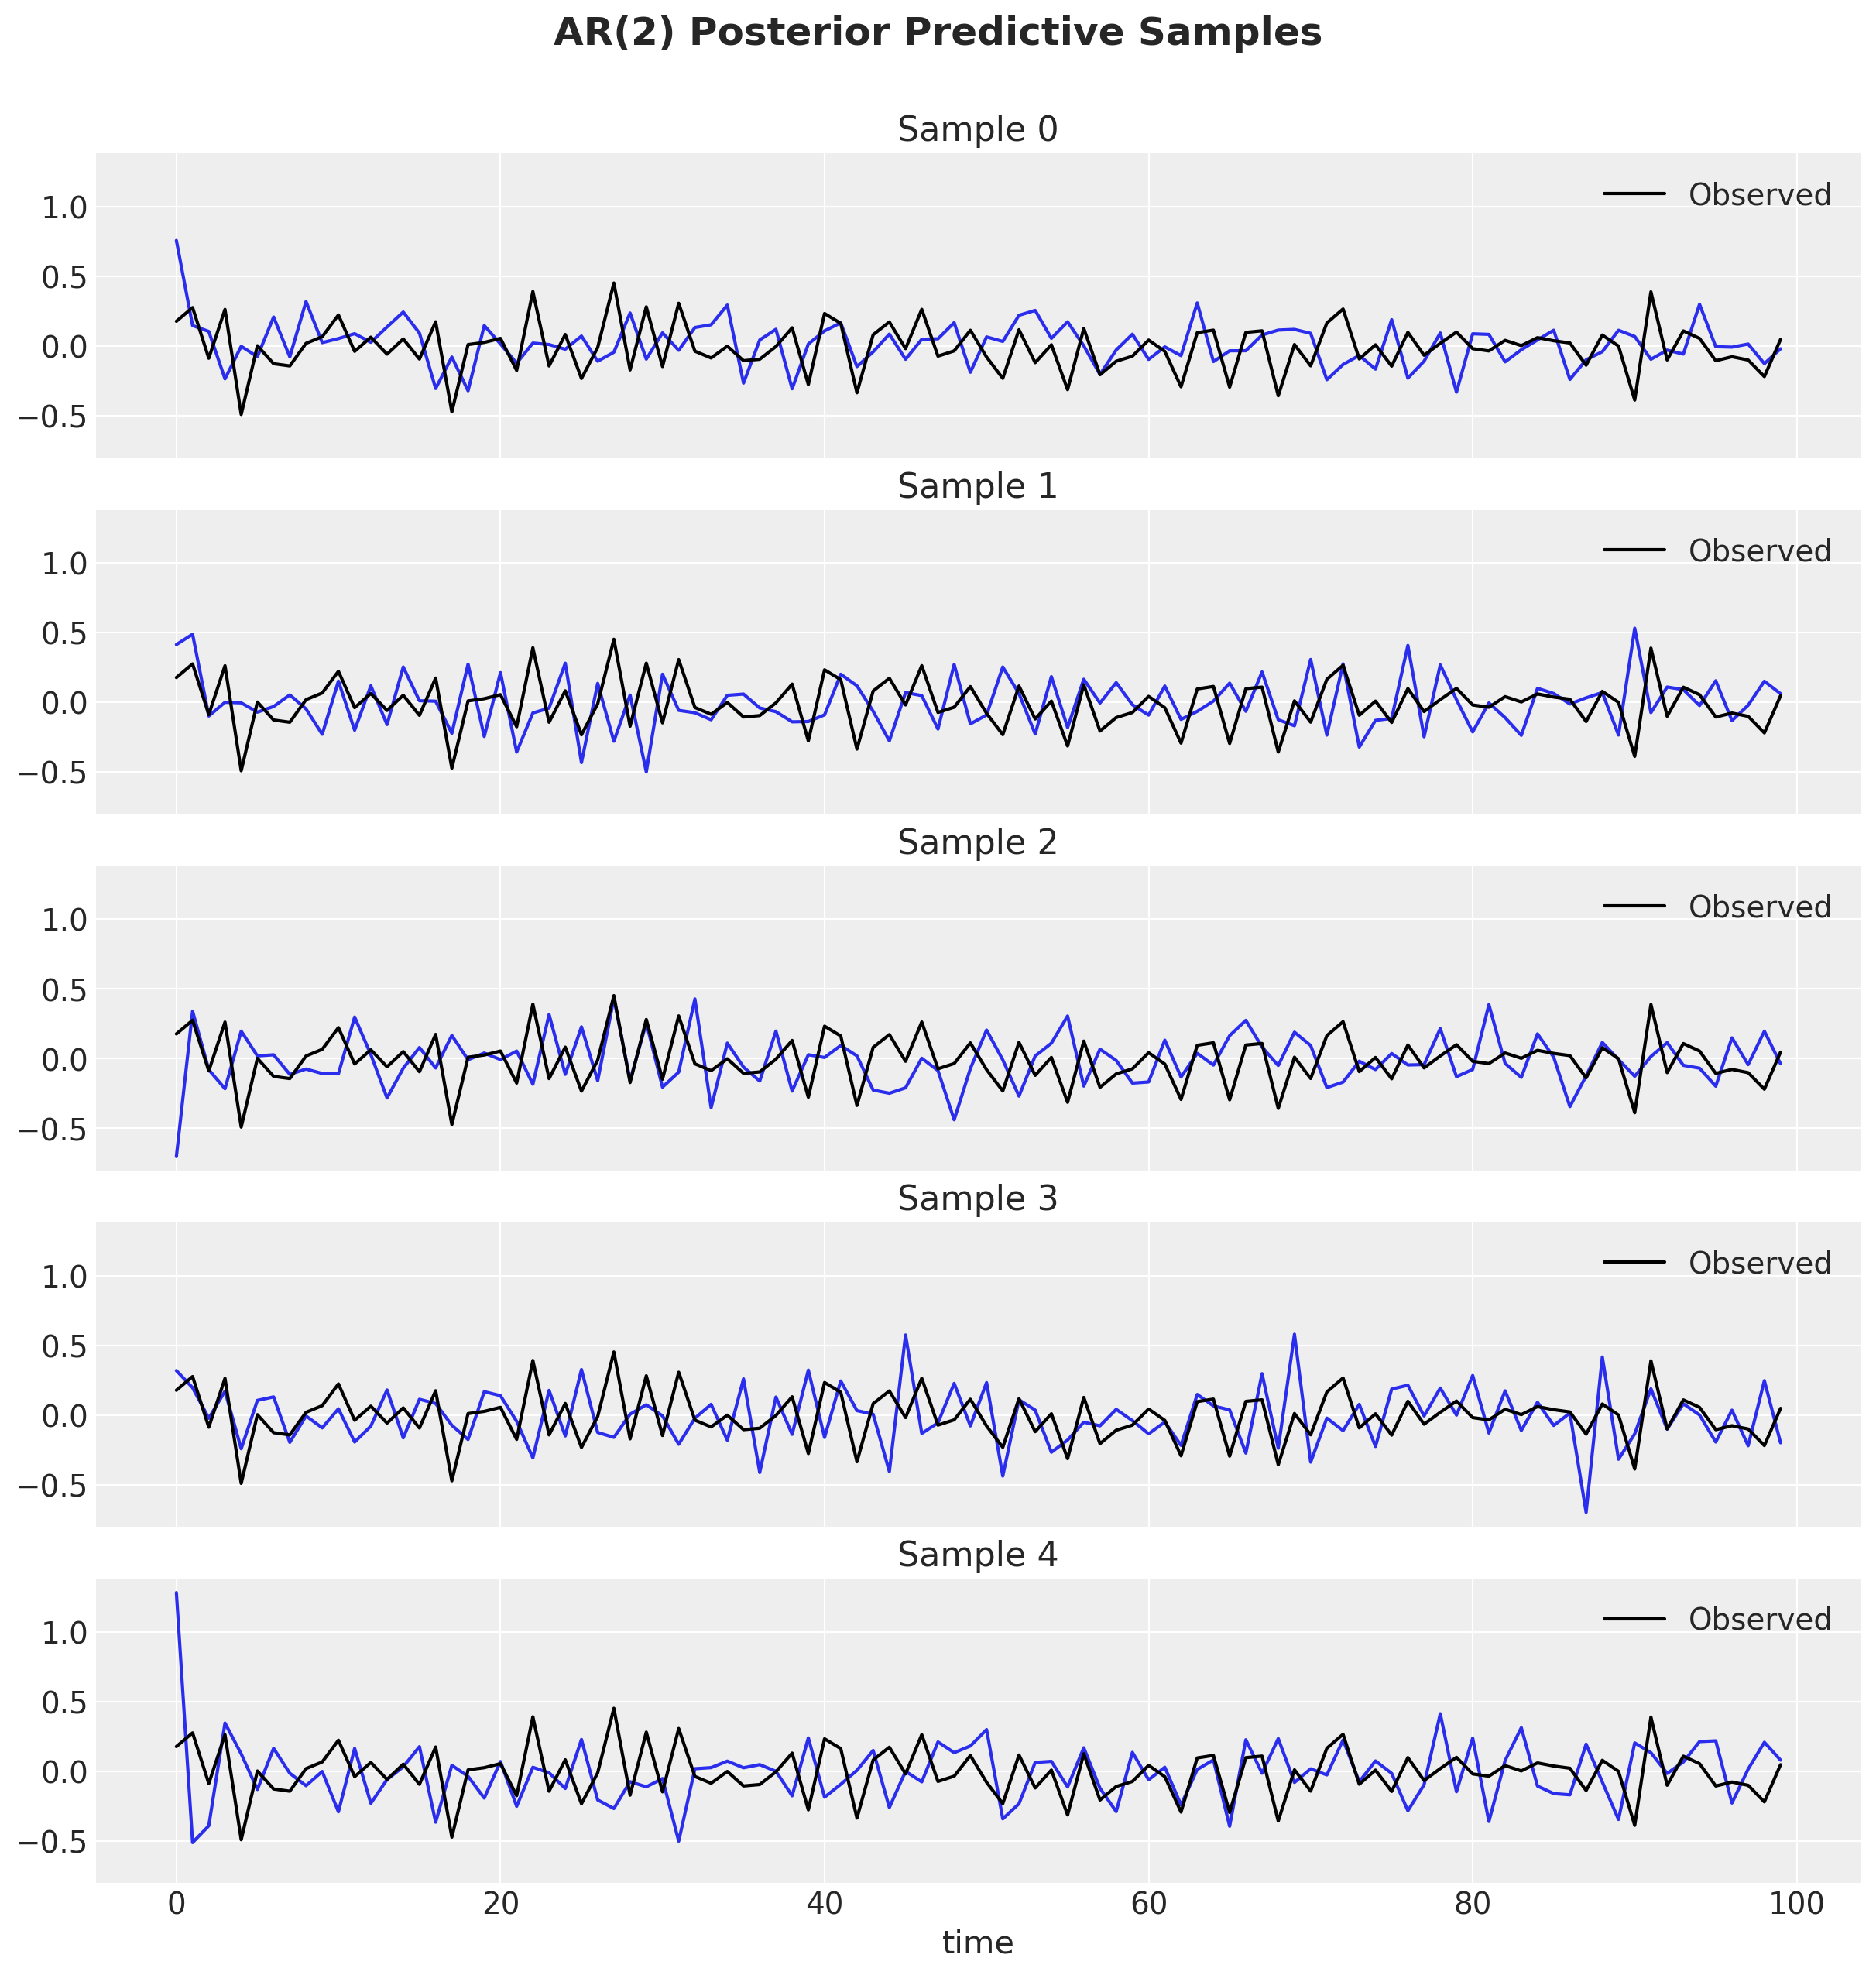

In [12]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12), sharex=True, sharey=True, layout="constrained"
)
for i, axi in enumerate(ax):
    axi.plot(post_pred.posterior_predictive["ar"].isel(draw=i, chain=0), color="C0")
    axi.plot(ar_obs, color="black", label="Observed")
    axi.legend(loc="upper right")
    axi.set_title(f"Sample {i}")

ax[-1].set_xlabel("time")

fig.suptitle("AR(2) Posterior Predictive Samples", fontsize=18, fontweight="bold", y=1.05);

:::{admonition} **Conditional and Unconditional Posteriors**
:class: warning

Many users will be surprised by this posterior because they are used to seeing conditional one-step forecasts, that is 

$$
P(x_{t} \: | \: \{ x_{\tau} \}_{\tau = 1} ^{t - 1})
$$


(what you get in statsmodels/stata/everything), which are much tighter and follow the data more closely.

:::

Let's see how to do this in PyMC! The key observation is that we need to pass the observed data explicitly into out "for loop" in the generative graph. That is, we need to pass it into the {meth}`scan <pytensor.scan.basic.scan>` function.

In [13]:
def conditional_ar_dist(y_data, ar_init, rho, sigma, size):
    def ar_step(x_tm2, x_tm1, rho, sigma):
        mu = x_tm1 * rho[0] + x_tm2 * rho[1]
        x = mu + pm.Normal.dist(sigma=sigma)
        return x, collect_default_updates([x])

    # Here we condition on the observed data by passing it through the `sequences` argument.
    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        sequences=[{"input": y_data, "taps": list(range(-lags, 0))}],
        non_sequences=[rho, sigma],
        n_steps=trials - lags,
        strict=True,
    )

    return ar_innov

Then we can simply generate samples from the posterior predictive distribution. Observe we need to "rewrite" the generative graph to include te conditioned transition step. Nevertheless, we will use the posterior samples from the model above, this means we can put *any* "prior" distributions on the parameters we learned. For a detailed explanation on these type of cross model predictions, see the great blog post [Out of model predictions with PyMC](https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/).

In [14]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(trials - lags),
    "trials": range(trials),
}
with pm.Model(coords=coords, check_bounds=False) as conditional_model:
    y_data = pm.Data("y_data", ar_obs)
    rho = pm.Flat(name="rho", dims=("lags",))
    sigma = pm.Flat(name="sigma")
    ar_init = pm.Flat(name="ar_init", dims=("lags",))

    ar_innov = pm.CustomDist(
        "ar_dist",
        y_data,
        ar_init,
        rho,
        sigma,
        dist=conditional_ar_dist,
        dims=("steps",),
    )

    ar = pm.Deterministic(
        name="ar", var=pt.concatenate([ar_init, ar_innov], axis=-1), dims=("trials",)
    )

    post_pred_conditional = pm.sample_posterior_predictive(trace, var_names=["ar"], random_seed=rng)

Sampling: [ar_dist]


Output()

Let's visualize the conditional posterior predictive distribution:

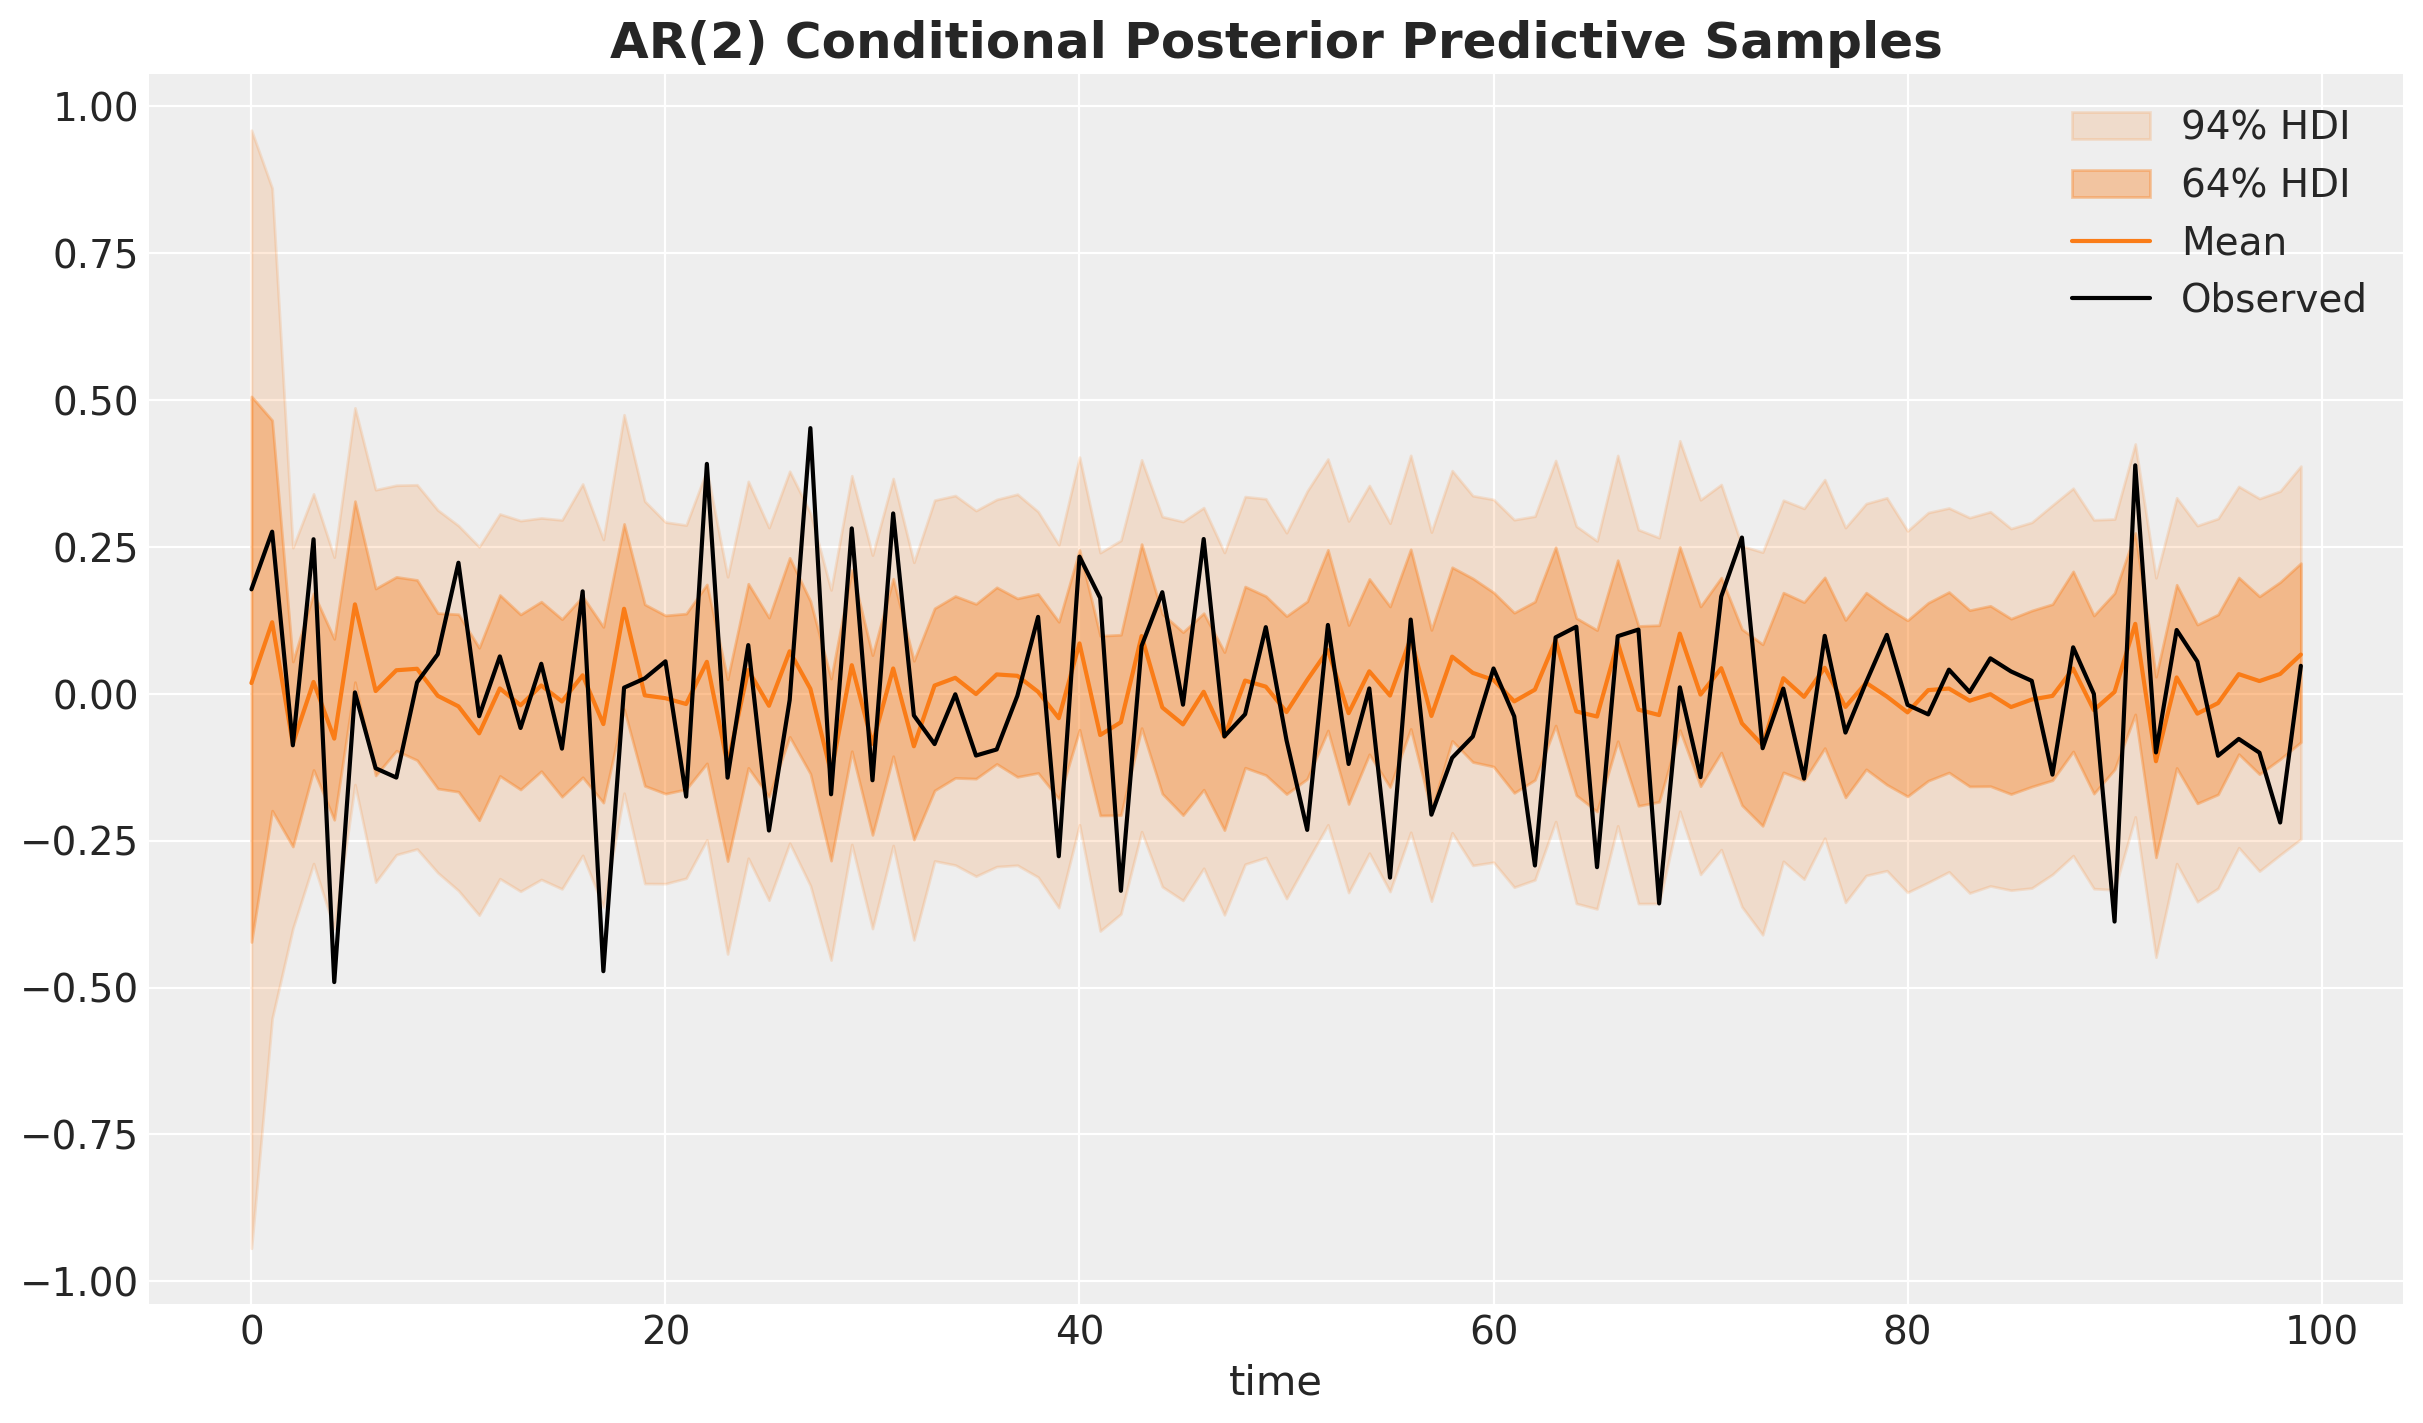

In [15]:
conditional_post_pred_ar = post_pred_conditional.posterior_predictive["ar"]

_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(conditional_post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(trials),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C1",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(conditional_post_pred_ar.mean(("chain", "draw")), color="C1", label="Mean")
ax.plot(ar_obs, color="black", label="Observed")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Conditional Posterior Predictive Samples", fontsize=18, fontweight="bold");

We indeed see that these credible intervals are tighter than the unconditional ones.

## Authors
- Authored by [Jesse Grabowski](https://github.com/jessegrabowski), [Juan Orduz](https://juanitorduz.github.io/) and [Ricardo Vieira](https://github.com/ricardoV94) in March 2024

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon May 06 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

pytensor: 2.20.0

pytensor  : 2.20.0
numpy     : 1.26.4
arviz     : 0.18.0
matplotlib: 3.8.4
pymc      : 5.14.0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::